# Hyperelasticity
Author: Jørgen S. Dokken and Garth N. Wells

This section shows how to solve the hyperelasticity problem for deformation of a beam.

We start by importing `dolfinx` and some additional dependencies.
Then, we create a slender cantilever consisting of hexahedral elements and create the function space `V` for our unknown.

In [42]:
import dolfinx
from dolfinx import fem, mesh
import numpy as np
import ufl
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.fem.petsc import NonlinearProblem

from petsc4py import PETSc
from mpi4py import MPI

L = 20.0
msh = dolfinx.mesh.create_box(MPI.COMM_WORLD, [(0.0, 0.0, 0.0), (L, 1.0, 1.0)], [50, 12, 12])

V = fem.VectorFunctionSpace(msh, ("Lagrange", 1))

We create two python functions for determining the facets to apply boundary conditions to

In [43]:
left_facets = mesh.locate_entities_boundary(msh, msh.topology.dim - 1, lambda x : np.isclose(x[0], 0))
right_facets = mesh.locate_entities_boundary(msh, msh.topology.dim - 1, lambda x: np.isclose(x[0], L))

Next, we create a  marker based on these two functions

In [44]:
# Concatenate and sort the arrays based on facet indices. Left facets marked with 1, right facets with two
marked_facets = np.hstack([left_facets, right_facets])
marked_values = np.hstack([np.full(len(left_facets), 1, dtype=np.int32), 
                           np.full(len(right_facets), 2, dtype=np.int32)])
sorted_facets = np.argsort(marked_facets)
facet_tag = mesh.meshtags(msh, msh.topology.dim-1, marked_facets[sorted_facets], marked_values[sorted_facets])

We then create a function for supplying the boundary condition on the left side, which is fixed.

To apply the boundary condition, we identity the dofs located on the facets marked by the `MeshTag`.

In [45]:
left_dofs = fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.indices[facet_tag.values==1])
bcs = [fem.dirichletbc(np.zeros(3, dtype=np.float64), left_dofs, V=V)]

Next, we define the body force on the reference configuration (`B`), and nominal (first Piola-Kirchhoff) traction (`T`). 

In [46]:
B = fem.Constant(msh, np.zeros(3, dtype=np.float64))
T = fem.Constant(msh, np.zeros(3, dtype=np.float64))

Define the test and solution functions on the space $V$

In [47]:
v = ufl.TestFunction(V)
u = fem.Function(V)

Define kinematic quantities used in the problem

In [48]:
# Spatial dimension
d = len(u)

# Identity tensor
I = ufl.variable(ufl.Identity(d))

# Deformation gradient
F = ufl.variable(I + ufl.grad(u))

# Right Cauchy-Green tensor
C = ufl.variable(F.T * F)

# Invariants of deformation tensors
Ic = ufl.variable(ufl.tr(C))
J  = ufl.variable(ufl.det(F))

Define the elasticity model via a stored strain energy density function $\psi$, and create the expression for the first Piola-Kirchhoff stress:

In [49]:
# Elasticity parameters
E, nu = 1.0e4, 0.3
mu = fem.Constant(msh, E/(2*(1 + nu)))
lmbda = fem.Constant(msh, E*nu/((1 + nu)*(1 - 2*nu)))

# Stored strain energy density (compressible neo-Hookean model)
psi = (mu / 2) * (Ic - 3) - mu * ufl.ln(J) + (lmbda / 2) * (ufl.ln(J))**2

# Stress (hyper-elastic)
P = ufl.diff(psi, F)

Define the variational form with traction integral over all facets with value 2. We set the quadrature degree for the integrals to 3.

In [50]:
metadata = {"quadrature_degree": 3}
ds = ufl.Measure('ds', subdomain_data=facet_tag, metadata=metadata)
dx = ufl.Measure("dx", metadata=metadata)

# Define form F (we want to find u such that F(u) = 0)
F = ufl.inner(ufl.grad(v), P)*dx - ufl.inner(v, B)*dx - ufl.inner(v, T)*ds(2)

The next step is to solve the non-linear problem. To do so, we use Newtons method. We start by creating a class containing the core functions that we require to solve the problem.

In [51]:
problem = NonlinearProblem(F, u, bcs)
solver = NewtonSolver(MPI.COMM_WORLD, problem)

and then create and customize the Newton solver

In [52]:
# Set Newton solver options
solver.atol = 1e-8
solver.rtol = 1e-6
solver.convergence_criterion = "incremental"

# We can customize the linear solver used inside the NewtonSolver by
# modifying the PETSc options
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
ksp.setFromOptions()

We create a function to plot the solution at each time step.

In [53]:
import pyvista as pv
import dolfinx.plot
import os

pv.global_theme.background = 'white'
if 'CODESPACES' in os.environ:
    pv.start_xvfb()
    jupyter_backend = 'static'
else:
    pv.set_jupyter_backend('trame')
    jupyter_backend='client'

Finally, we solve the problem over several time steps, updating the y-component of the traction

In [54]:
# dolfinx.log.set_log_level(dolfinx.log.LogLevel.WARNING)
tval0 = -1.5
for n in range(1, 10):
    print("Step:", n)
    T.value[2] = n * tval0
    num_its, converged = solver.solve(u)
    assert converged

# Solve linear problem
v = ufl.TestFunction(V)
ut = ufl.TrialFunction(V)
P_l = 2.0 * mu * ufl.sym(ufl.grad(ut)) + lmbda * ufl.tr(ufl.sym(ufl.grad(ut))) * I
a = ufl.inner(ufl.grad(v), P_l)*dx 
L = ufl.inner(v, B)*dx + ufl.inner(v, T)*ds(2) 
problem_l = fem.petsc.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
u_l = problem_l.solve()

Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9


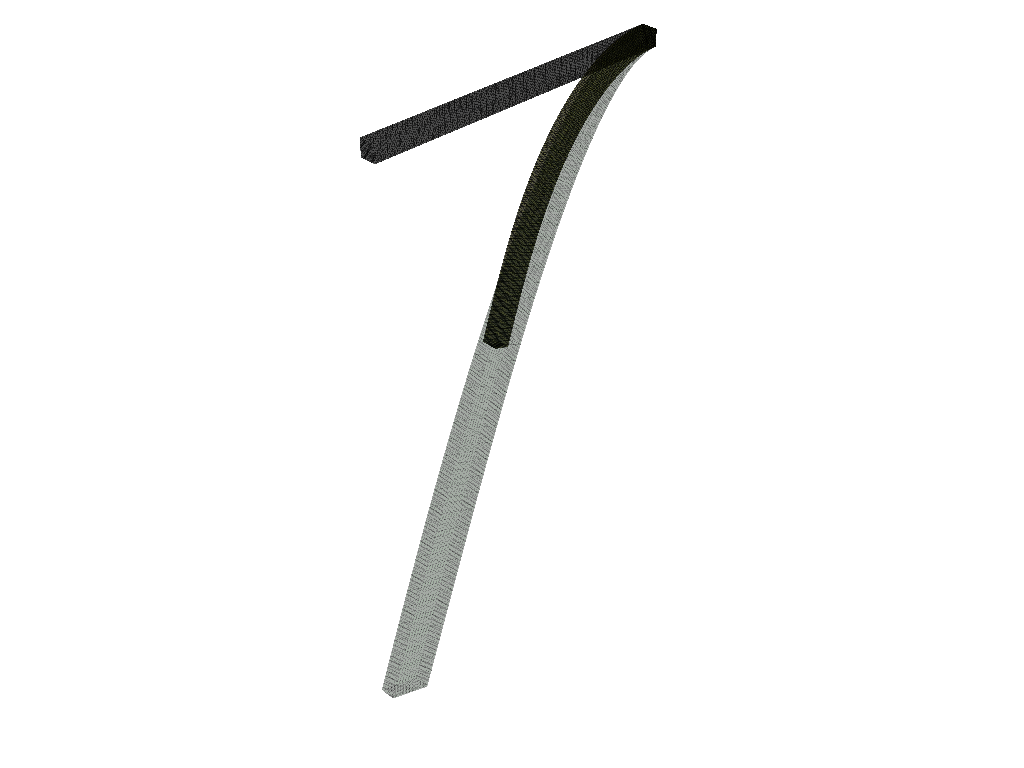

In [55]:
# Plot
cells, types, x = dolfinx.plot.create_vtk_mesh(msh)
grid = pv.UnstructuredGrid(cells, types, x)

grid.point_data["u"] = u.x.array.reshape(x.shape[0], msh.topology.dim)
grid.point_data["u_l"] = u_l.x.array.reshape(x.shape[0], msh.topology.dim)

# Create a 'warped' version with the displacement magnified by a factor
warped0 = grid.warp_by_vector("u", factor=1.0)
warped1 = grid.warp_by_vector("u_l", factor=1.0)


pl = pv.Plotter(notebook=True)
pl.add_mesh(grid, color='grey', opacity=0.5, show_edges=True)
pl.add_mesh(warped0, color='yellow', show_edges=True, opacity=0.5, label="Nonlinear")
pl.add_mesh(warped1, color='green', show_edges=True, opacity=0.2, label="Linear")
pl.show(jupyter_backend=jupyter_backend)